In [2]:
import pandas as pd 
import numpy as np 
import pandas as pd
import requests
import json
import time
import datetime as dt
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from functions.data_reader import YFinanceReader, AlphaVantageReader

In [2]:
# ticker_list = [v + market_suffix for s in stock_sectors.values() for v in s]
# ticker_list = ['GC=F']
# yfinance_meta = yf.Tickers(ticker_list)
# is_loaded = False

gold_price_raw = yf.download('GC=F', dt.date(2000, 1, 1), dt.date(2023, 8, 29), auto_adjust=True)
gold_price_raw.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-08-22,1894.599976,1896.800049,1892.800049,1896.400024,46
2023-08-23,1909.599976,1918.500000,1909.599976,1918.500000,547
2023-08-24,1920.000000,1920.800049,1918.199951,1918.199951,337
2023-08-25,1919.800049,1919.800049,1911.099976,1911.099976,195
2023-08-28,1915.500000,1921.500000,1915.500000,1917.900024,99


In [55]:
# pull data from FRED
fred_keys = {
    "DFF": "fed_funds_rate",
    "IRLTLT01USM156N": "us_10y",
    "USALOLITONOSTSAM": "us_lei",
    "USACPIALLMINMEI": "us_cpi",
    "USACPICORMINMEI": "us_core_cpi",
    "CSCICP03USM665S": "consumer_opinion_surveys",
    "TOTDTEUSQ163N": "us_de_ratio",
    "DDDI06USA156NWDB": "fed_asset_to_gdp",
    "DDDM03USA156NWDB": "domestic_private_debt",
    "TRESEGUSM052N": "total_reserve_exclude_gold"
}

In [60]:
def read_fred(symbol:str, name:str = None):
    raw = pdr.get_data_fred(symbol, start='2000-01-01', end='2023-08-31')
    if name:
        raw.columns = [name]
    return raw

In [93]:
fred_data = [read_fred(k, v) for k, v in fred_keys.items()]
fred_df = pd.concat(fred_data, axis=1)
fred_df.index = pd.to_datetime(fred_df.index)

# clean values
for c in fred_df.columns:
    fred_df[c] = fred_df[c].apply(lambda x: None if x == 'NaN' or np.isnan(x) else x)

In [147]:
# save data
# fred_df.to_parquet('./data/us/economic_data/fred_data.parquet')
fred_df = pd.read_parquet('./data/us/economic_data/fred_data.parquet')

In [151]:
k = 'us_core_cpi'
series = fred_df[['us_core_cpi']].dropna()
series[]
series.head()

,us_core_cpi
DATE,
2000-01-01,73.809116
2000-02-01,74.098078
2000-03-01,74.510880
2000-04-01,74.676002
2000-05-01,74.676002


In [150]:
# calculate diff for monthly data
non_daily_cols = ['us_10y', 'us_lei', 'us_cpi', 'us_core_cpi', 'consumer_opinion_surveys', 
                  'us_de_ratio', 'fed_asset_to_gdp', 'domestic_private_debt', 'total_reserve_exclude_gold']
for c in non_daily_cols:
    series = fred_df[c]
    

In [96]:
# for columns that do not come in daily format, mark the announcement date, and perform forward-fill
for c in non_daily_cols:
    fred_df[f'is_{c}_existed'] = ~fred_df[c].isnull()
    fred_df[c] = fred_df[c].ffill()
fred_df.head()

,fed_funds_rate,us_10y,us_lei,us_cpi,us_core_cpi,consumer_opinion_surveys,us_de_ratio,fed_asset_to_gdp,domestic_private_debt,total_reserve_exclude_gold,is_us_10y_existed,is_us_lei_existed,is_us_cpi_existed,is_us_core_cpi_existed,is_consumer_opinion_surveys_existed,is_us_de_ratio_existed,is_fed_asset_to_gdp_existed,is_domestic_private_debt_existed,is_total_reserve_exclude_gold_existed
DATE,,,,,,,,,,,,,,,,,,,
2000-01-01,3.99,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,True,True,True,True,True,False,True,True,True
2000-01-02,3.99,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-03,5.43,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-04,5.38,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False
2000-01-05,5.41,6.66,101.222012,71.21852,73.809116,102.827566,NaN,4.991082,94.6063,5.884971e+10,False,False,False,False,False,False,False,False,False


<h1 style="color:turquoise">Pull data from Alphavantage</h1>
Reference: <a href="https://www.alphavantage.co/documentation/#intelligence">Alphavantage API Docs</a>

In [2]:
# Alphavantage
with open('./keys/creds.json') as f:
    keys = json.load(f)
    key = keys['AlphaVantage']

In [3]:
avr = AlphaVantageReader(key=key)

# * get treasury yield data
bond_yield_df = avr.get_us_bond_yield(maturity_list=['3month', '2year', '5year', '7year', '10year', '30year'], interval='daily')

In [7]:
bond_yield_df.tail()

,us_3month,us_2year,us_5year,us_7year,us_10year,us_30year
date,,,,,,
2023-08-25,5.61,5.03,4.44,4.37,4.25,4.30
2023-08-28,5.58,4.98,4.38,4.32,4.20,4.29
2023-08-29,5.56,4.87,4.26,4.21,4.12,4.23
2023-08-30,5.56,4.90,4.27,4.22,4.12,4.23
2023-08-31,5.56,4.85,4.23,4.19,4.09,4.20


In [8]:
# save data
base_export_path = './data/us/bond_yield'
years = bond_yield_df.index.year.unique()
for y in years:
    year_df = bond_yield_df[bond_yield_df.index.year == y]
    year_df.to_parquet(f'{base_export_path}/{y}.parquet')

Text(0.5, 1.0, 'US Bond Yield - 10 Year minus 2 Year')

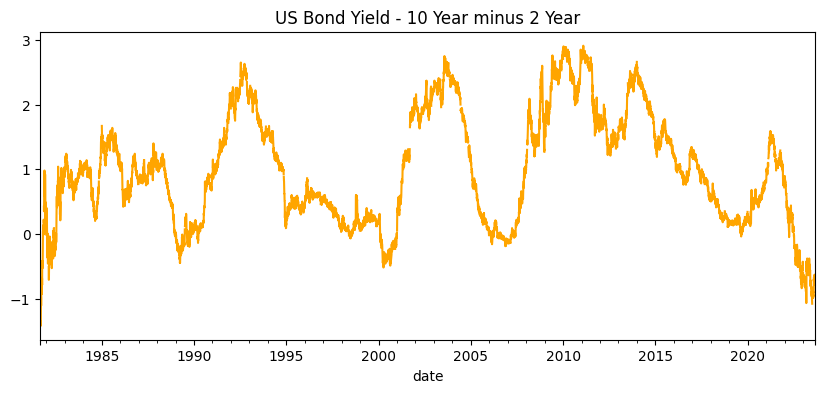

In [5]:
us_2y_10y = bond_yield_df['us_10year'] - bond_yield_df['us_2year']
us_2y_10y = us_2y_10y[us_2y_10y.index >= dt.datetime(1981, 9, 1)]
us_2y_10y.plot(color='orange', figsize=(10, 4))
plt.title('US Bond Yield - 10 Year minus 2 Year')

<h1 style="color:turquoise">AAII Sentiment Survey Data</h1>
Source: <a href="https://www.aaii.com/sentimentsurvey/sent_results">AAII Official Website</a> (manually download)

In [109]:
AAII_COLUMNS = ['date', 'bullish', 'neutral', 'bearish', 'total', 'bullish_ma_8week', 
                'bull_bear_spread', 'bullish_avg', 'bullish_avg_plus_sd', 'bullish_avg_minus_sd', 
                'sp500_week_high', 'sp500_week_low', 'sp500_week_close']

In [142]:
aaii_raw = pd.read_excel('./data/us/aaii/aaii_sentiment.xls', header=0, skiprows=4)
aaii_raw.columns = AAII_COLUMNS
# aaii_raw['date'] = pd.to_datetime(aaii_raw['date'])

# remove unused rows
aaii_raw['is_date_valid'] = aaii_raw['date'].str.contains(r'[0-9]-:', regex=True)
aaii_df = aaii_raw[aaii_raw['is_date_valid'] != False]
aaii_df['date'] = pd.to_datetime(aaii_df['date'])
aaii_df = aaii_df[~aaii_df['date'].isnull()]

/var/folders/cg/6xrmgcbj71nfsp9hqcxq2fzh0000gn/T/ipykernel_8036/861195033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aaii_df['date'] = pd.to_datetime(aaii_df['date'])


In [146]:
aaii_df.tail(3)

,date,bullish,neutral,bearish,total,bullish_ma_8week,bull_bear_spread,bullish_avg,bullish_avg_plus_sd,bullish_avg_minus_sd,sp500_week_high,sp500_week_low,sp500_week_close,is_date_valid
1881,2023-08-10,0.446991,0.297994,0.255014,0.999999,0.452653,0.191977,0.375351,0.476882,0.273821,4527.37,4487.16,4524.67,NaN
1882,2023-08-17,0.358904,0.339726,0.301370,1.000000,0.442237,0.057534,0.375315,0.476799,0.273830,4421.70,4405.76,4410.25,NaN
1883,2023-08-24,0.322700,0.318100,0.359300,1.000100,0.430473,-0.036600,0.375315,0.476799,0.273830,4421.70,4405.76,4448.61,NaN
